In [1]:
# If you want to use 25 ms window length with 10 ms hop
# This feature extraction is based on pyannote library

f = open("featureplan_new.txt", "w")
f.write("mfcc: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=19 \n"
        "mfcc_d1: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=19 > Derivate DOrder=1 \n"
        "mfcc_d2: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=19 > Derivate DOrder=2 \n"
        "energy_d1: Energy blockSize=400 stepSize=160 > Derivate DOrder=1 \n"
        "energy_d2: Energy blockSize=400 stepSize=160 > Derivate DOrder=2")
f.close() 

In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from numpy import genfromtxt
import numpy as np
import os
import glob

import librosa
import os
import glob
import numpy as np
import math
import sys

def create_numpy_for_audio(audio_file, featureplan = "", hop=10, win_len=25, sr=16000):
    """This function is based on YAAFE or Librosa. It will return 2D Array which is features of audio file. 
    Also it will save the numpy array.
    
    Its arguments:
    audio_file: Path of audio file, it can be wav, mp3, ogg etc.
    featureplan: Text file which introduce which features will be extracted.(for Yaafe)
    feature_extractor: Which library will be used to extract features.
    hop: Hop length (we need it for Librosa)
    win_len: Window length (we need it for Librosa)
    sr: Sample rate for audio file. Default as 16000."""
    
    if (feature_extractor=="yaafe"):
        !yaafe -c $featureplan -r $sr $audio_file -p Precision=6 -p Metadata=False -n
        filename = (audio_file.split("/")[-1]).split(".")[0]

        my_data = genfromtxt(audio_file + ".mfcc.csv", delimiter=',')
        my_data = np.append(my_data, genfromtxt(audio_file + ".mfcc_d1.csv", delimiter=','), axis=1)
        my_data = np.append(my_data, genfromtxt(audio_file + ".mfcc_d2.csv", delimiter=','), axis=1)

        my_data = np.append(my_data, np.expand_dims(genfromtxt(audio_file + ".energy_d1.csv", delimiter=','), axis=1), axis=1)
        my_data = np.append(my_data, np.expand_dims(genfromtxt(audio_file + ".energy_d2.csv", delimiter=','), axis=1), axis=1)

        # Previous codes creates csv file for features to load numpy array. After that, we can 
        # remove them.
        os.remove(audio_file + ".mfcc.csv")
        os.remove(audio_file + ".mfcc_d1.csv")
        os.remove(audio_file + ".mfcc_d2.csv")
        os.remove(audio_file + ".energy_d1.csv")
        os.remove(audio_file + ".energy_d2.csv")
        
        np.save("./yaafe_ami_storage/" + filename, my_data)

        return my_data

In [3]:
import math
import numpy as np
import glob
import os
import matplotlib.pyplot as pp
import more_itertools as mit

%matplotlib inline

def create_data_for_supervised(root_dir, hop, win_len, from_ep=0, to_ep=0, boost_for_imbalance=False, 
                              how_much_boost=6,
                              feature_extractor="pyannote",
                              fuzzy_label=False):
    
    """If we have numpy array in the folder, it will create input and output array via this function.
    
    Arguments:
    root_dir: The folder which stores numpy array.
    hop: Hop length (we need it for Librosa).
    win_len: Window length (we need it for Librosa).
    from_ep: Location of first file which will be loaded into array.
    to_ep: Location of last file which will be loaded into array.
    boost_for_imbalance: If it is true, the number of positive labels is
        increased artificially by labeling as positive every frame in the
        direct  neighborhood  of  the  manually  annotated  change  point
        and this number will be determined by how_much_boost parameter.
    balance: if it is true, we will discard some frame which are at the 
        middle of single speaker segment.
    feature_extractor: Which library will be used. (now, we can use Pyannote or Yaafe.)
    fuzzy_label: If it is true, we will label the neighboorhood frames
        with decreasing number. (for instance: if we will use 5 frame as a boost
        middle frame will be 1, next frame will be 0.8, next one will be 0.6)
    """
    
    audios_path = glob.glob(os.path.join(root_dir, '*wav'))
    input_array = []
    
    output= []
    
    num = 0
    
    for single_audio_path in audios_path:
        
        num += 1
        
        if ((num >= from_ep) and (num < to_ep)):
            
            change_seconds = []

            filename = (single_audio_path.split("/")[-1]).split(".")[0]
            print (filename)
            
            if (feature_extractor == "pyannote"):
                feature_vector = np.load("./pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".Mix-Headset.npy")

            if (feature_extractor == "yaafe"):
                feature_vector = np.load("./yaafe_ami_storage/" + filename + ".Mix-Headset.npy")

                print (feature_vector.shape)

            feature_array = np.ravel(feature_vector)

            if (feature_vector is not None):

                input_array.extend(feature_array)

                print (single_audio_path + " is done.")

                path_for_output = "./txt_ami_full/" + filename + "_full_time.txt"

                with open(path_for_output) as f:
                    content = f.readlines()

                content = [x.strip() for x in content] 

                for single_change in content:

                    change_seconds.append(single_change)

                output_array = np.zeros(feature_vector.shape[0])

                for single_change in change_seconds:

                    single_change_ms = float(single_change)*1000

                    which_start_hop = (single_change_ms-win_len)/hop # now we know, milisecond version of change
                                                # which is located after which_hop paramater
                                                # add 2 and round to up

                    which_end_hop = single_change_ms/hop # round to up

                    start_location = math.ceil(which_start_hop + 1)
                    end_location = math.ceil(which_end_hop)

                    if (boost_for_imbalance==False):

                        output_array[start_location:end_location+1] = 1.0

                    else:

                        if (fuzzy_label==False):
                            output_array[start_location-how_much_boost:end_location+1+how_much_boost] = 1.0
                        else:
                            output_array[start_location:end_location+1] = 1.0
                            for ix_label in range(1, how_much_boost):
                                output_array[start_location-ix_label] = 1.0 - (float(ix_label)/how_much_boost)
                                output_array[end_location+1+ix_label] = 1.0 - (float(ix_label)/how_much_boost)

                output.extend(output_array)

    input_array = np.reshape(input_array, (-1, 59))
        
    output_array = np.asarray(output)
    output_array = np.expand_dims(output_array, axis=1)
    
    print("inputs shape: ", input_array.shape)

    print("outputs shape: ", output_array.shape)

    return (input_array, output_array)

In [6]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import load_model
import time
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (800, 59)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(128, activation="tanh", return_sequences=True))(input_frame)
bidirectional_1_drop = layers.Dropout(0.2)(bidirectional_1)
bidirectional_2 = layers.Bidirectional(layers.LSTM(80, activation='tanh', return_sequences=True))(bidirectional_1_drop)

tdistributed_1 = layers.TimeDistributed(layers.Dense(100, activation='tanh'))(bidirectional_2)
tdistributed_1_drop = layers.Dropout(0.2)(tdistributed_1)
tdistributed_2 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(tdistributed_1_drop)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_2)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.00001)

model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=["accuracy"])

In [7]:
how_many_step = 10
how_many_repeat = 50

ix_repeat = 0


while (ix_repeat < how_many_repeat):
    ix_repeat += 0
    
    print ("REPEAT:", ix_repeat)
    ix_step = 0
    from_epi = 1
    
    while (ix_step < how_many_step):
        ix_step += 1

        print ("STEP:", ix_step)
        
        #print("relax")
        #time.sleep(2.5) 
    
        try:
            input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 10, 25, from_epi, 
                                                                    from_epi+5, True, 60, "yaafe", True)

            print (np.mean(output_array))
            max_len = 800 # how many frame will be taken
            step = 800 # step size.

            input_array_specified = []
            output_array_specified = []

            for i in range (0, input_array.shape[0]-max_len, step):
                single_input_specified = (input_array[i:i+max_len,:])
                single_output_specified = (output_array[i:i+max_len,:])

                input_array_specified.append(single_input_specified)
                output_array_specified.append(single_output_specified)

            output_array_specified = np.asarray(output_array_specified)
            input_array_specified = np.asarray(input_array_specified)


            try:
                model.fit(input_array_specified, output_array_specified,
                       epochs=4,
                       batch_size=16,
                       validation_split=0.2,
                       shuffle=False)

            except:
                print ("Pass this epoch.")
                pass
        except:
            print ("Possibly file error.")
            pass

        # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

        model.save_weights('bilstm_weights_yaafe.h5')    

        input_array = []
        output_array = []

        from_epi += 3
    model.save_weights("bilstm_weights_yaafe" + str(ix_repeat) + ".h5")    


REPEAT: 0
STEP: 1
IS1000d
(261834, 59)
./amicorpus/IS1000d/audio/IS1000d.Mix-Headset.wav is done.
IS1007c
(211317, 59)
./amicorpus/IS1007c/audio/IS1007c.Mix-Headset.wav is done.
ES2016a
(138419, 59)
./amicorpus/ES2016a/audio/ES2016a.Mix-Headset.wav is done.
IS1004c
(226384, 59)
./amicorpus/IS1004c/audio/IS1004c.Mix-Headset.wav is done.
TS3005c
(240300, 59)
./amicorpus/TS3005c/audio/TS3005c.Mix-Headset.wav is done.
inputs shape:  (1078254, 59)
outputs shape:  (1078254, 1)
0.21168132307724652
Train on 1077 samples, validate on 270 samples
Epoch 1/4
1077/1077 [==============================] - 67s 63ms/step - loss: 0.5114 - acc: 0.5942 - val_loss: 0.5847 - val_acc: 0.5262
Epoch 2/4
1077/1077 [==============================] - 65s 61ms/step - loss: 0.5069 - acc: 0.5945 - val_loss: 0.5848 - val_acc: 0.5263
Epoch 3/4
1077/1077 [==============================] - 65s 61ms/step - loss: 0.5049 - acc: 0.5945 - val_loss: 0.6245 - val_acc: 0.5263
Epoch 4/4
1077/1077 [==============================]

KeyboardInterrupt: 

In [8]:
# To get prediction, we need to give k, 800, 59 array to system.
# Our output is like k, 320, 1
# We need to convert it into milisecond version

import more_itertools as mit

def create_prediction(filename, hop, win_len, threshold, lstm_system, featureplan, sr, feature_extractor="yaafe"):
    
    """"It takes audio file and create prediction via lstm system. If output exceeds
    threshold, we will say there is speaker change.
    
    Arguments:
    filename= Which file will be considered.
    hop: Hop length (we need it for Librosa)
    win_len: Window length (we need it for Librosa)
    threshold: If prediction exceed this value, we will say there is speaker change
    lstm_system: System will create prediction
    featureplan: Which txt will be used for yaafe feature extraction.
    sr: Sample rate of audio input.
    
    Outputs:
    prediction_array: It stores prediction value for each frame
    prediction_array_rav: Ravel version of prediction array. We will use it.
    prediction_array_ms = It stores which milisecond we have speaker change point.
    """
    
    prediction_vector = []
    
    if (feature_extractor=="pyannote"):
        feature_vector = np.load("./pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".npy")

    if (feature_extractor=="yaafe"):
        
        try:
            feature_vector = np.load("./yaafe_ami_storage/" + filename + ".npy")
        except: 
            feature_vector = create_numpy_for_audio(audio_file="rad_bremen_media/" + filename + ".wav", 
                                                            feature_extractor="yaafe", 
                                                            hop=hop, win_len=win_len, 
                                                            featureplan=featureplan, sr=sr)
    ix_frame = 0
    
    
    print (feature_vector.shape[0])

    while (ix_frame+799<feature_vector.shape[0]):        

        prediction = lstm_system.predict(np.expand_dims(feature_vector[ix_frame:ix_frame+800], axis=0))

        prediction_vector.append(prediction)
        ix_frame += 800

    prediction_vector = np.asarray(prediction_vector)
    print (prediction_vector.shape)

    prediction_array = np.ravel(prediction_vector)


    prediction_array_sec = []
    prediction_array_msec = []
    ix_frame_pred = 0

    for pred in prediction_array:
        if (pred > threshold):
            ms_version = float(win_len + (ix_frame_pred * hop)) # milisecond version to represent end point of first embed            
            prediction_array_msec.append(int(ms_version))
            prediction_array_sec.append(ms_version/1000)

        ix_frame_pred += 1

    prediction_array_tenth_ms = np.asarray(prediction_array_msec)/10

    list_cons = [list(group) for group in mit.consecutive_groups(prediction_array_tenth_ms)]

    prediction_array_msec_smooth = []

    for single_list_cons in list_cons:
        prediction_array_msec_smooth.append(np.mean(single_list_cons)*0.01)

    prediction_array_msec_smooth = np.asarray(prediction_array_msec_smooth)

    which_turn = 0

    for single_mean_s in prediction_array_msec_smooth:
        which_turn += 1

        try:
            start_time = float(prediction_array_msec_smooth[which_turn-1])
            end_time = float(prediction_array_msec_smooth[which_turn])

            if ((start_time+0.5) > end_time):
                mean_s[which_turn] = ((start_time+end_time) / 2)
                mean_s = np.delete(mean_s, which_turn-1)
                which_turn -= 1

        except:
            pass

                
    # https://codereview.stackexchange.com/questions/5196/grouping-consecutive-numbers-into-ranges-in-python-3-2

    np.savetxt(fname="./prediction_txt/" + filename + "_prediction.txt", 
               X=prediction_array_msec_smooth, 
               delimiter=' ', fmt='%1.3f')

    return (prediction_array, prediction_array_msec_smooth)


In [9]:
def txt_file_to_matrix (filename, type_of_text, sr, featureplan, hop=10, win_len=25, feature_extractor="yaafe"):
    
    
    """It takes the reference(ground truth) text file or prediction text file (they are in second version) and 
    return output array which represent the which frames has a speaker change point.
    
    Arguments:
    filename: Which file will be considered.
    type_of_text: Is it prediction or reference file.
    sr: Sample rate.
    featureplan: Which txt will be used for yaafe feature extraction.
    hop: Hop length. (for Librosa.)
    win_len: Window length. (for Librosa)
    feature_extractor: Which feature extractor will be used. (Now, we have 2 option as
        Pyannote or Yaafe.)"""
    
    
    if (feature_extractor=="pyannote"):
        feature_vector = np.load("./pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".npy")
        
    if (feature_extractor=="yaafe"):
        try:
            feature_vector = np.load("./yaafe_ami_storage/" + filename + ".npy")
        except: 
            feature_vector = create_numpy_for_audio(audio_file="rad_bremen_media/" + filename + ".wav", 
                                                            feature_extractor="yaafe", hop=hop, win_len=win_len, 
                                                            featureplan=featureplan, sr=sr)
    
    
    if (type_of_text == "reference"):
        path_for_txt = "./txt_ami_full/" + filename.split(".")[0] + "_full_time.txt" 
        print (path_for_txt)
    
    if (type_of_text == "prediction"):
        path_for_txt = "./prediction_txt/" + filename + "_prediction.txt"
        
    change_seconds = []


    with open(path_for_txt) as f:
        content = f.readlines()
        
    content = [x.strip() for x in content] 
    
    for single_change in content:
        change_seconds.append(single_change)
    
    output_array = np.zeros(feature_vector.shape[0])

    for single_change in change_seconds:
        
        single_change_ms = float(single_change)*1000
        which_start_hop = (single_change_ms-win_len)/hop # now we know, milisecond version of change
                                    # which is located after which_hop paramater
                                    # add 2 and round to up
        start_location = math.ceil(which_start_hop + 1)

        output_array[start_location] = 1.0

    return (output_array)

In [25]:
# Evaluation Metric
from pyannote.metrics.diarization import DiarizationPurityCoverageFMeasure
from pyannote.metrics.segmentation import SegmentationPurity
from pyannote.metrics.segmentation import SegmentationCoverage
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.database import get_protocol
from pyannote.core import Segment, Timeline, Annotation


metric = DiarizationPurityCoverageFMeasure()
seg_purity = SegmentationPurity()
seg_coverage = SegmentationCoverage()

def complete_evaluation_single_file(filename, hop, win_len, thres, model, sr, featureplan, feature_extractor):
    
    """With this function, we can get different metrics to evaluate the system's performance.
    
    Arguments:
    filename: Which file will be considered.
    hop: Hop length.
    win_len: Window length.
    thres:
    model: Which Deep Learning model will be used to predict.
    sr: Sample rate of input.
    featureplan:
    overlapping: Will we use overlapping-averaging to predict output.
    show_graph_frame: If it is true, we can see the prediction
        and ground truth at the figure.
    feature_extractor: Which feature extractor will be used. (currently, 
        Pyannote and Yaafe are available.)"""
    
    
    prediction_array, prediction_array_msec = create_prediction(filename, hop=hop, win_len=win_len, 
                                                                threshold = thres, lstm_system=model,
                                                                featureplan=featureplan,
                                                                sr=sr,
                                                                feature_extractor=feature_extractor,)
    
    ground_truth = txt_file_to_matrix(filename, "reference", sr, featureplan, 
                                      hop=hop, win_len=win_len, feature_extractor=feature_extractor)
    
    prediction_output_array = txt_file_to_matrix(filename, "prediction", sr, featureplan, 
                                                 hop=hop, win_len=win_len, feature_extractor=feature_extractor)
    
    path_for_reference = "./txt_ami_full/" + filename.split(".")[0] + "_full_time.txt"
   
        
    path_for_prediction = "./prediction_txt/" + filename + "_prediction.txt"
   
        
    with open(path_for_reference) as f:
        change_seconds_ref = f.readlines()
        
    change_seconds_ref = [x.strip() for x in change_seconds_ref] 
    
    change_miliseconds_ref = [int(1000*float(i)) for i in change_seconds_ref]
    
    x_axis = np.arange(1, len(ground_truth)+1)
    
    pp.rcParams['figure.figsize'] = (50.8, 10.0)
    pp.plot(prediction_array[40000:60000])
    pp.plot(x_axis[0:20000], ground_truth[40000:60000], 'x', color='black');
    # pp.plot(x_axis, 0.95*prediction_output_array, '.', color="pink");
    
    # pp.axhline(y=thres, color='r', linestyle='-')
    pp.show()

150565
(188, 1, 800, 1)
./txt_ami_full/TS3003a_full_time.txt


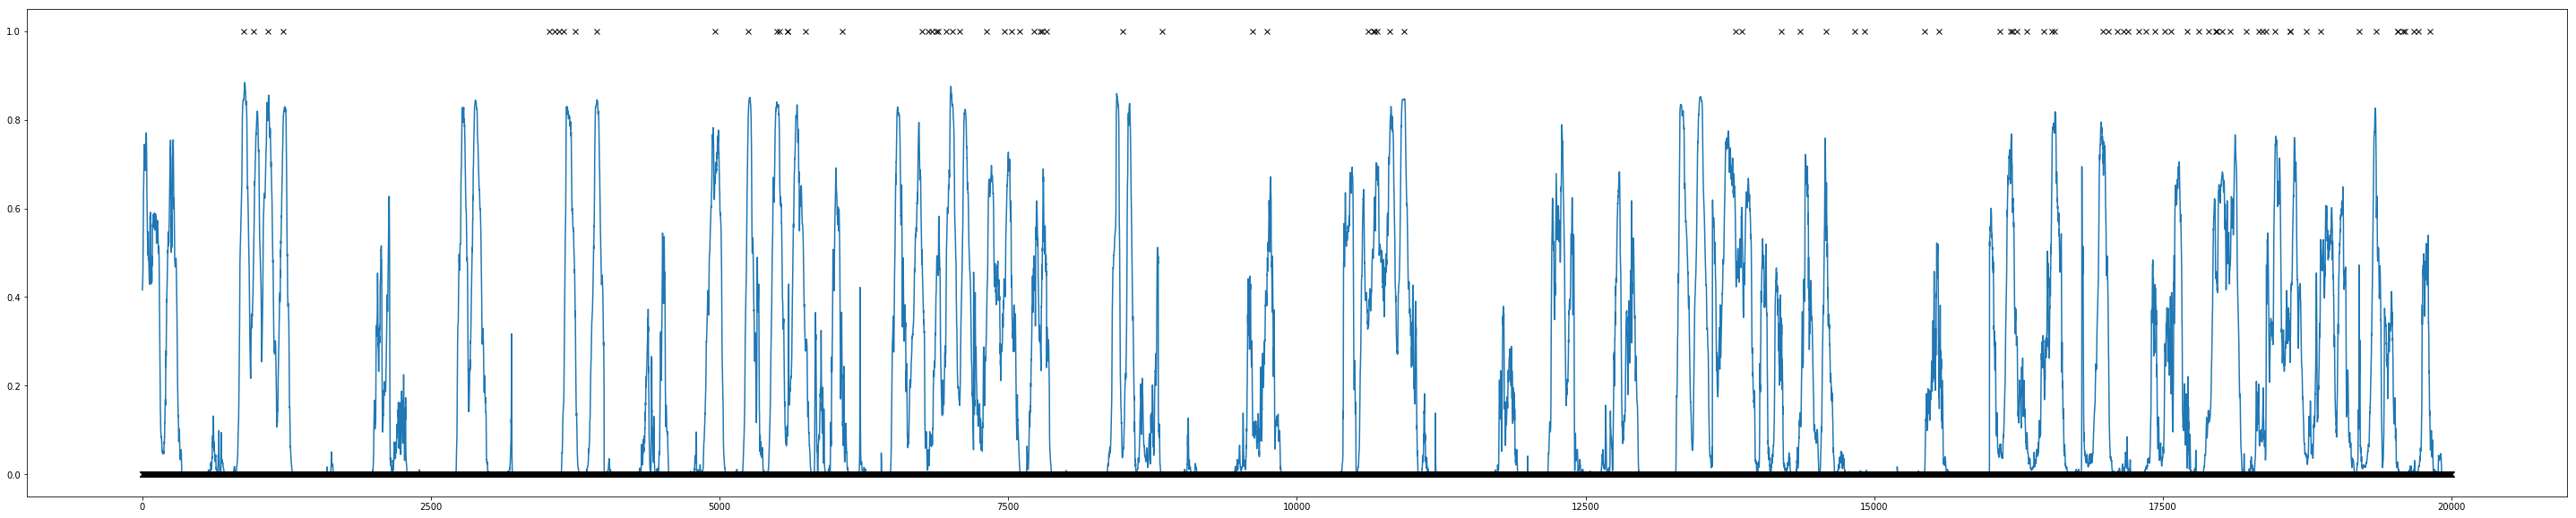

In [26]:
complete_evaluation_single_file(filename="TS3003a.Mix-Headset", hop=10, win_len=25, thres = 0.18, 
                               model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt")

85935
(107, 1, 800, 1)
./txt_ami_full/TS3012a_full_time.txt


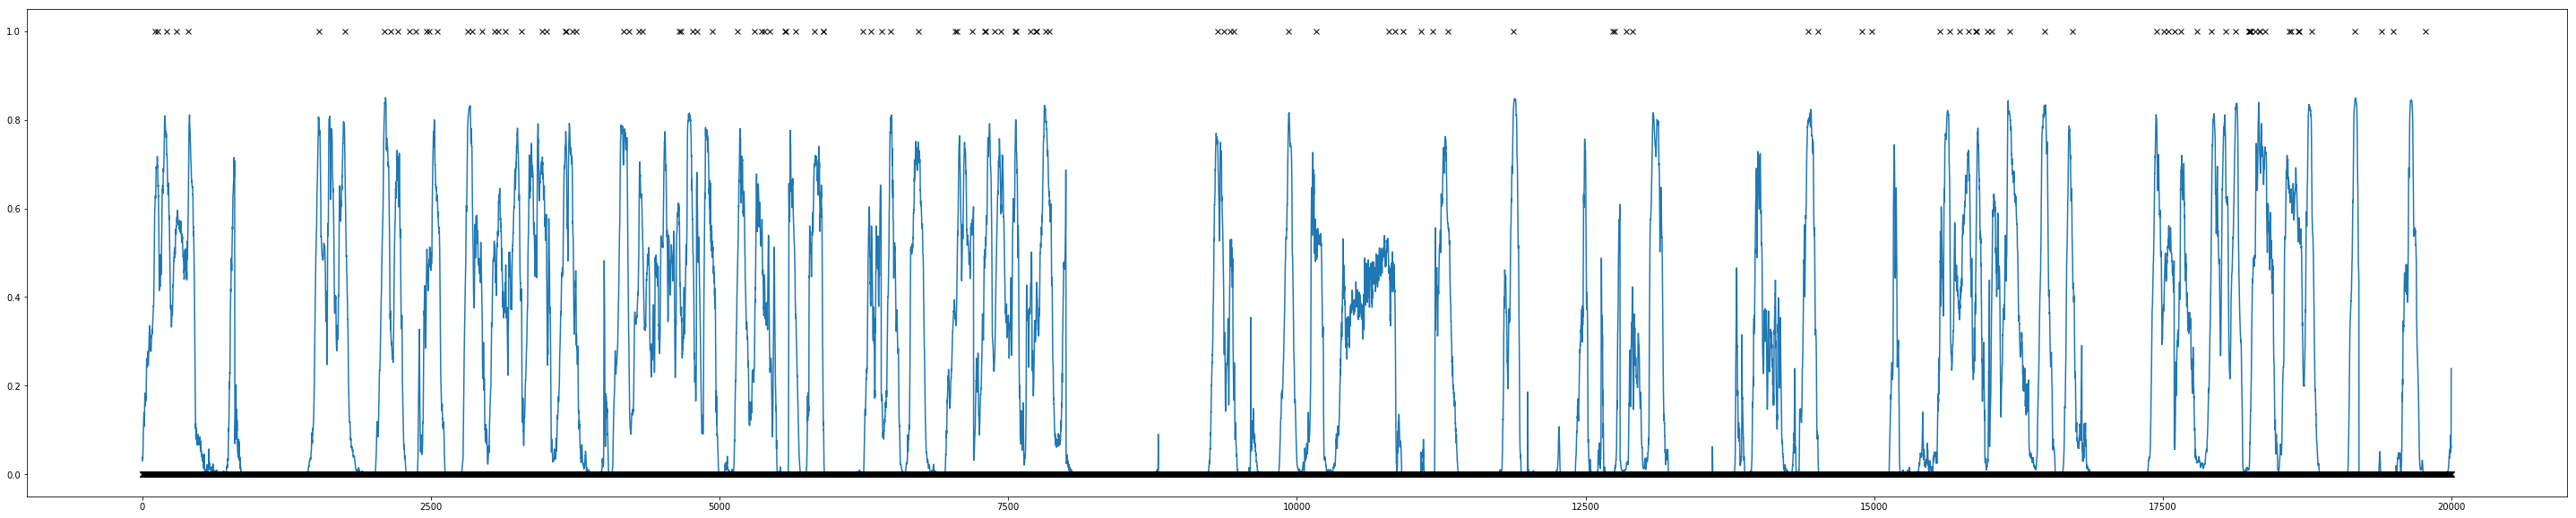

In [27]:
complete_evaluation_single_file(filename="TS3012a.Mix-Headset", hop=10, win_len=25, thres = 0.18, 
                               model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt")

138419
(173, 1, 800, 1)
./txt_ami_full/ES2016a_full_time.txt


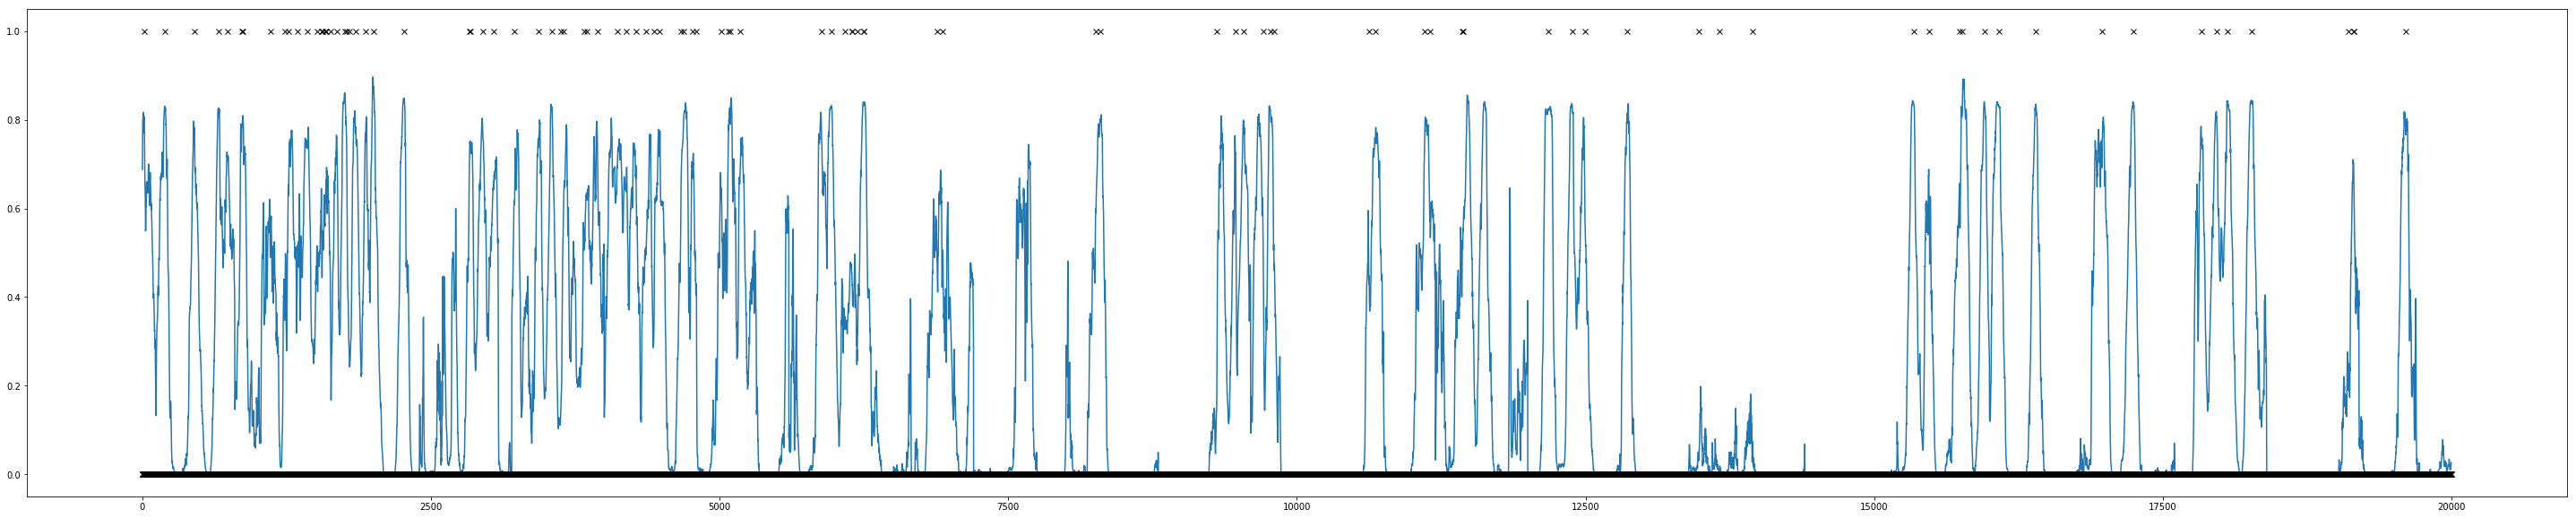

In [28]:
complete_evaluation_single_file(filename="ES2016a.Mix-Headset", hop=10, win_len=25, thres = 0.18, 
                               model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt")

221031
(276, 1, 800, 1)
./txt_ami_full/TS3003b_full_time.txt


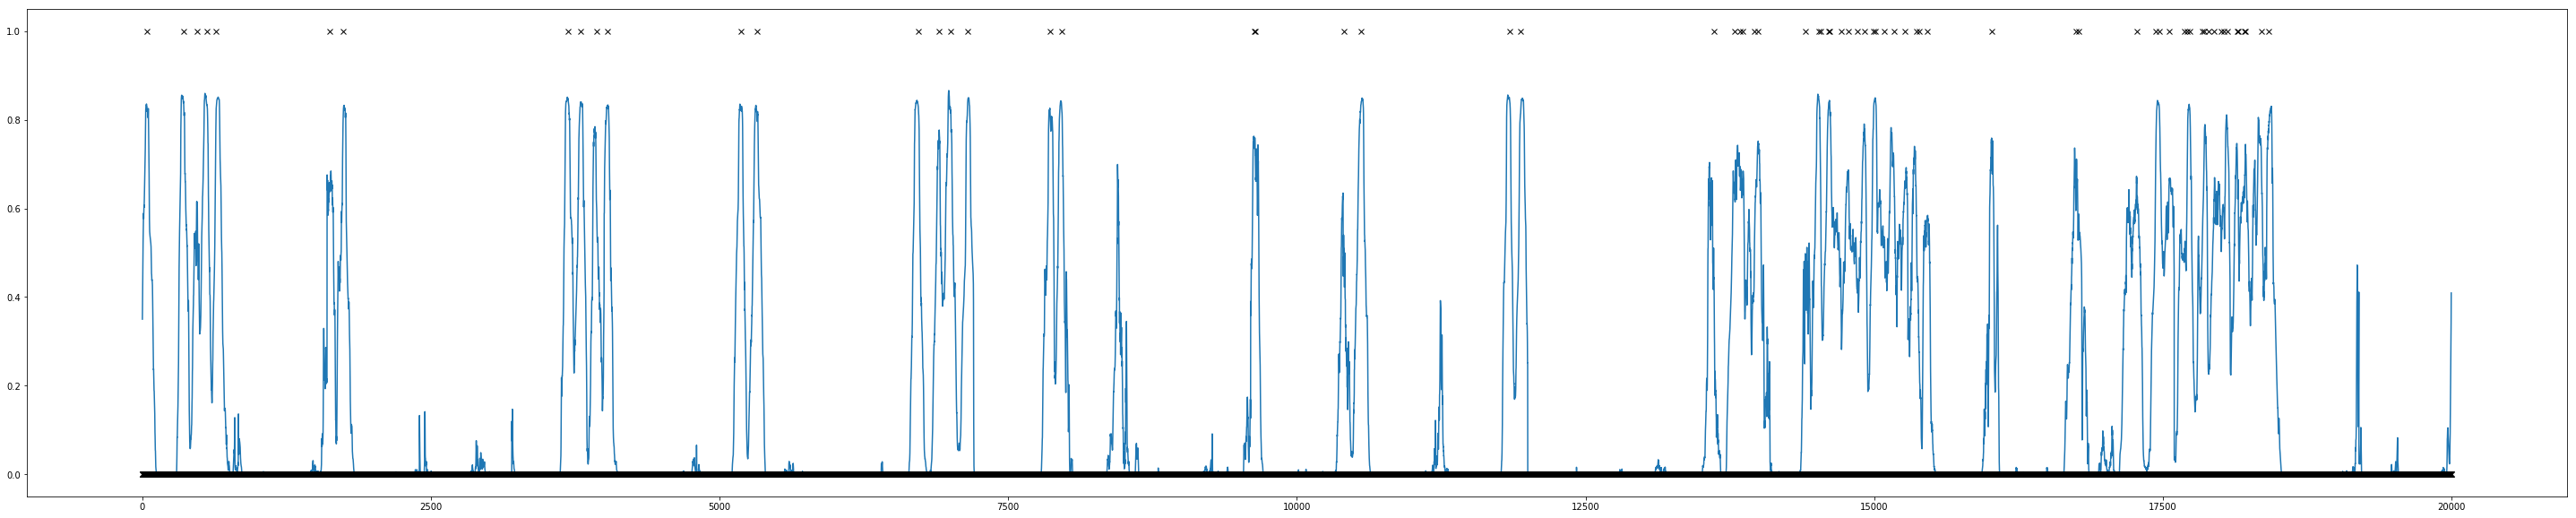

In [29]:
complete_evaluation_single_file(filename="TS3003b.Mix-Headset", hop=10, win_len=25, thres = 0.18, 
                               model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt")